In [2]:
cd ..

/playpen-raid1/tgreer/ICON


In [3]:
import training_scripts.brain_t1_pipeline.train as train
#import training_scripts.brain_t1_pipeline.train_quarter as trainq


from icon_registration import itk_wrapper
import itk
import matplotlib.pyplot as plt
import torch
import glob

In [4]:
ls /playpen-raid1/tgreer/InverseConsistency/training_scripts/brain_t1_pipeline/results

 brain_train/    'dermpy attempt lncc'/   quarter_stripped/     stripped/
 brain_train-1/   lncc.7/                 quarter_stripped-1/   stripped_rg.05/


In [5]:
##net = train.make_network()
#weights_path = "/playpen-raid1/tgreer/InverseConsistency/\
#training_scripts/brain_t1_pipeline/results/stripped_rg.05/brain_aligner_resi_net30900"
#net.regis_net.load_state_dict(torch.load(weights_path), strict=False)

In [6]:
net = train.make_network()
weights_path = "/playpen-raid1/tgreer/InverseConsistency/training_scripts/brain_t1_pipeline/results/lncc.7/knee_aligner_resi_net99900"
net.regis_net.load_state_dict(torch.load(weights_path), strict=False)

<All keys matched successfully>

In [7]:
#net = trainq.make_network()
#weights_path = "/playpen-raid1/tgreer/InverseConsistency/\
#training_scripts/brain_t1_pipeline/results/quarter_stripped-1/brain_aligner_resi_net18000"
#net.regis_net.load_state_dict(torch.load(weights_path))

In [8]:
ls /playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/

101915/  131217/  140925/  149539/  163129/  199655/  298051/  672756/
123117/  133019/  146432/  149741/  188347/  201111/  397760/  751348/
124422/  133928/  147737/  153025/  189450/  208226/  414229/  856766/
126325/  135225/  148335/  159340/  190031/  211417/  499566/  857263/
130013/  138534/  149337/  162733/  198451/  212318/  654754/  899885/


In [9]:
import glob
paths = glob.glob("/playpen-raid1/tgreer/Subcortical_Atlas_Fusion2/*WarpedLabels*")
atlas_registered = [p.split("/malf3")[-1].split("_")[0] for p in paths]
atlas_registered

['190031',
 '201111',
 '151223',
 '113922',
 '118730',
 '114419',
 '140925',
 '113619',
 '124422',
 '130013',
 '146432',
 '154734',
 '178950',
 '162733',
 '176542',
 '160123',
 '188347',
 '189450',
 '199655',
 '196750',
 '198451',
 '208226',
 '212318',
 '397760',
 '414229',
 '499566']

In [10]:
def preprocess(image):
    #image = itk.CastImageFilter[itk.Image[itk.SS, 3], itk.Image[itk.F, 3]].New()(image)
    image = itk.shift_scale_image_filter(image, shift=0., scale = 1 / 1000)
    image = itk.clamp_image_filter(image, bounds=(0, 1))
    return image

#NA = "101915"
#NB = "131217"

#NA = "162733"
#NB = "198451"

#NA = "149337"
#NB = "201111"

NA = "140925"
NB = "146432"

def get_sub_seg(n):
    path = f"/playpen-raid1/tgreer/Subcortical_Atlas_Fusion2/{n}_label.nii.gz"
    return itk.imread(path)
    

image_A = itk.imread(
    f"/playpen-raid2/Data/HCP/HCP_1200/{NA}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
image_A = preprocess(image_A)
image_B = itk.imread(
    f"/playpen-raid2/Data/HCP/HCP_1200/{NB}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
image_B = preprocess(image_B)
#image_A_seg = itk.imread(
#    glob.glob(f"/playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/{NA}/{NA}_*_novdc-label.nii.gz")[0])
#image_B_seg = itk.imread(
#    glob.glob(f"/playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/{NB}/{NB}_*_novdc-label.nii.gz")[0])

image_A_seg = get_sub_seg(NA)
image_B_seg = get_sub_seg(NB)

In [11]:
phi_AB, phi_BA = itk_wrapper.register_pair(net, image_A, image_B, finetune_steps=50)

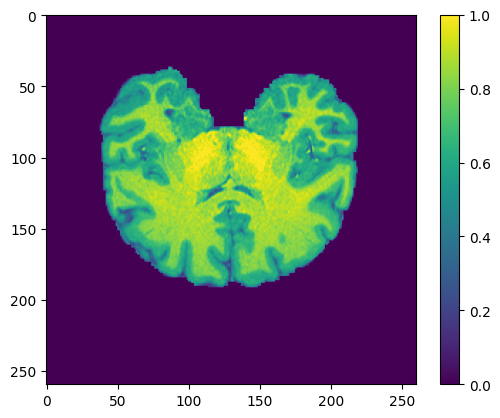

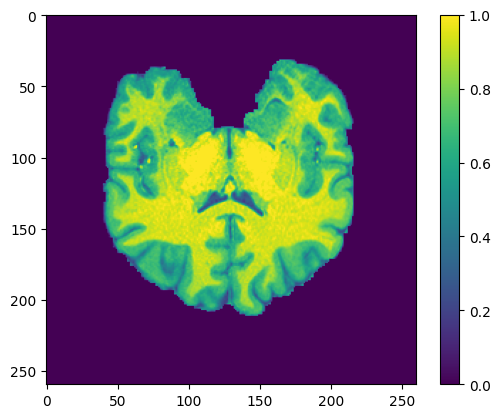

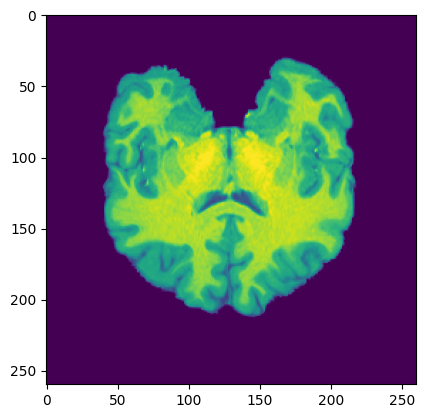

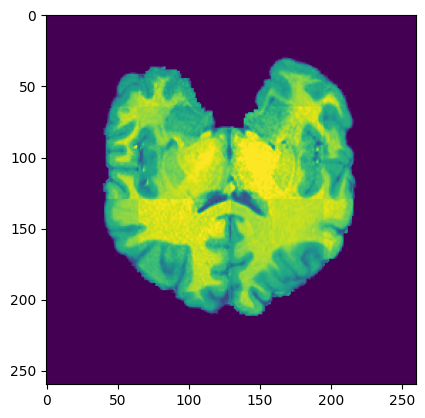

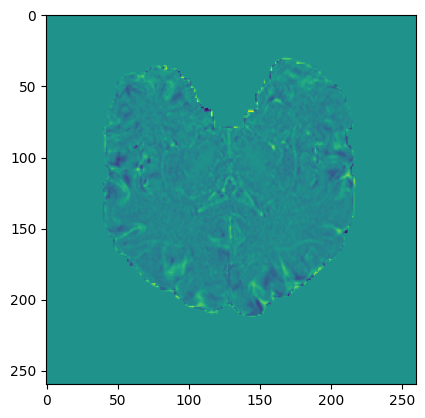

In [12]:
interpolator = itk.LinearInterpolateImageFunction.New(image_A)
warped_image_A = itk.resample_image_filter(image_A, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

S = 170
plt.imshow(image_A[:, S])
plt.colorbar()
plt.show()
plt.imshow(image_B[:, S])
plt.colorbar()
plt.show()

plt.imshow(warped_image_A[:, S])
plt.show()

plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[:, S])
plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A, image_B)[:, S])


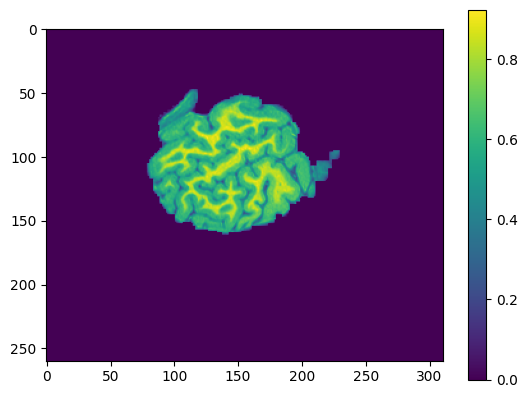

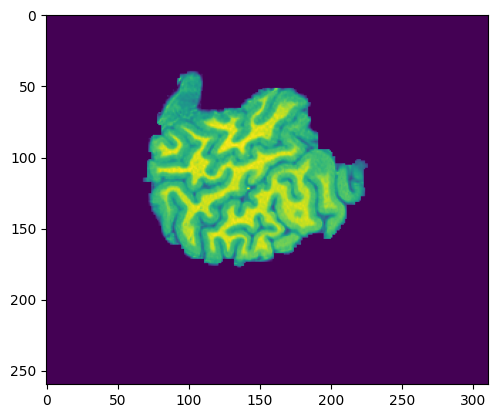

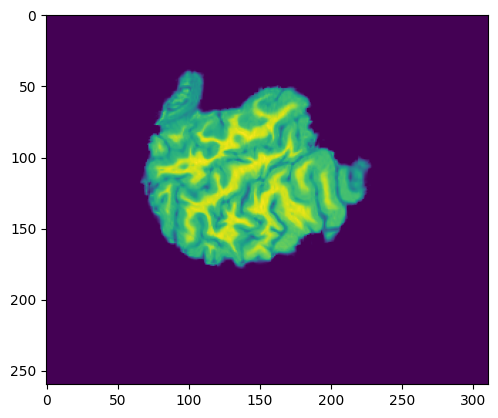

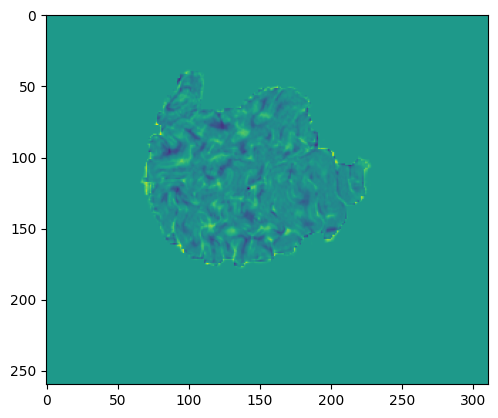

In [16]:
S = 205
plt.imshow(image_A[:, :, S])
plt.colorbar()
plt.show()
plt.imshow(image_B[:, :, S])
plt.show()

plt.imshow(warped_image_A[:, :, S])
plt.show()

#plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[:, 90])
#plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A, image_B)[:,:, S])

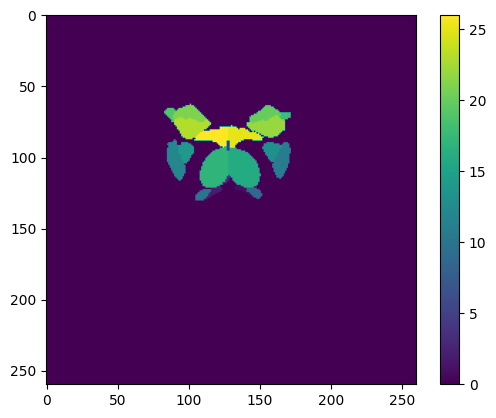

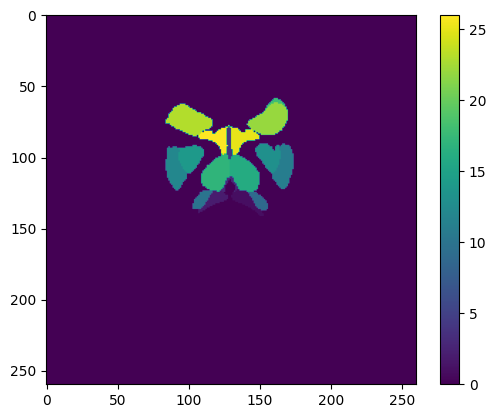

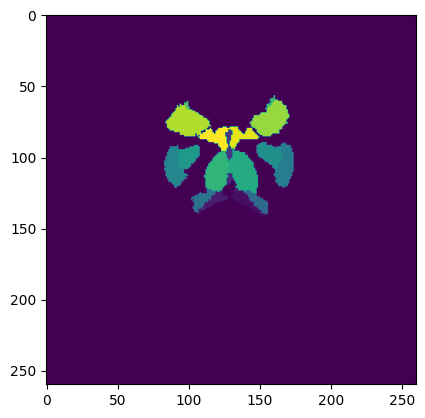

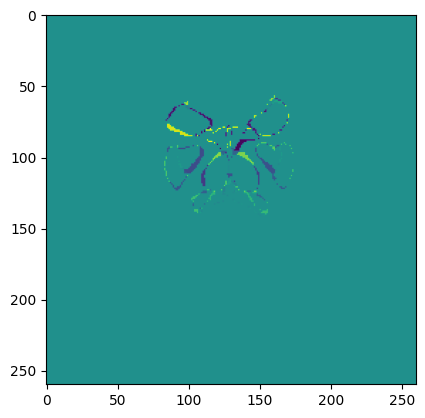

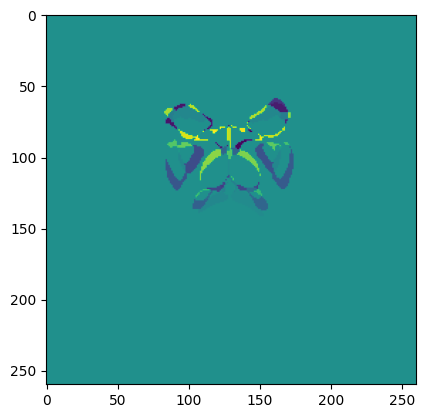

In [17]:
interpolator = itk.NearestNeighborInterpolateImageFunction.New(image_A_seg)
warped_image_A_seg = itk.resample_image_filter(image_A_seg, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

S = 170
plt.imshow(image_A_seg[:, S])
plt.colorbar()
plt.show()
plt.imshow(image_B_seg[:, S])
plt.colorbar()
plt.show()

plt.imshow(warped_image_A_seg[:, S])
plt.show()

#plt.imshow(itk.checker_board_image_filter(warped_image_A_seg, image_B_seg)[:, S])
#plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A_seg, image_B_seg)[:, S])
plt.show()

plt.imshow(itk.subtract_image_filter(image_A_seg, image_B_seg)[:, S])


In [15]:
import numpy as np
def meanDICE(im1, im2):
    array1 = itk.array_from_image(im1)
    array2 = itk.array_from_image(im2)
    dices = []
    #print(set(array1.flatten()))
    for index in range(1, int(max(np.max(array1), np.max(array2)) + 1)):
        m1 = array1 == index
        m2 = array2 == index
        
        intersection = np.logical_and(m1, m2)
        
        d = 2 * np.sum(intersection) / (np.sum(m1) + np.sum(m2))
        dices.append(d)
    return np.mean(dices)
print(meanDICE(image_A_seg, image_B_seg))
print(meanDICE(warped_image_A_seg, image_B_seg))

0.49332913650791477
0.7859367355458042


In [18]:
meanDICE(warped_image_A_seg, image_B_seg)

0.7859367355458042

In [19]:
def get_ants_seg(n):
    import glob
    path = glob.glob(f"/playpen-raid1/tgreer/Subcortical_Atlas_Fusion2/malf3{n}_T1w_acpc_dc_restore_*_WarpedLabels.nii.gz")[0]
    return itk.imread(path)

meanDICE(get_ants_seg(NA), get_ants_seg(NB))

0.7752614787290227

In [35]:
atlas = itk.imread("/playpen-raid1/tgreer/Subcortical_Atlas_Fusion2/ants50template.nii.gz")

phi_A_atlas, _ = itk_wrapper.register_pair(net, image_A, atlas, finetune_steps=50)

In [36]:
interpolator = itk.NearestNeighborInterpolateImageFunction.New(image_A_seg)
warped_A_atlas = itk.resample_image_filter(image_A_seg, 
    transform=phi_A_atlas, 
    interpolator=interpolator,
    use_reference_image=True, 
    reference_image=atlas
)

In [37]:
phi_B_atlas, _ = itk_wrapper.register_pair(net, image_B, atlas, finetune_steps=50)

In [38]:
interpolator = itk.NearestNeighborInterpolateImageFunction.New(image_B_seg)
warped_B_atlas = itk.resample_image_filter(image_B_seg, 
    transform=phi_B_atlas, 
    interpolator=interpolator,
    use_reference_image=True, 
    reference_image=atlas
)

In [50]:
meanDICE(warped_A_atlas, warped_B_atlas)

0.7109380608257317

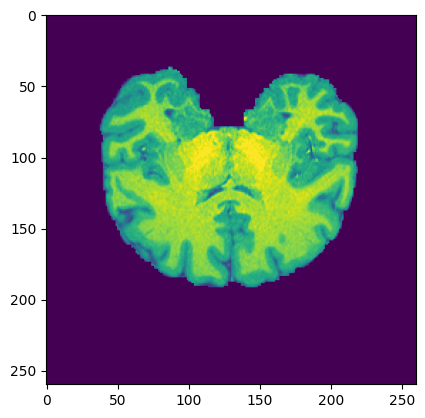

In [41]:
plt.imshow(image_A[:, S])

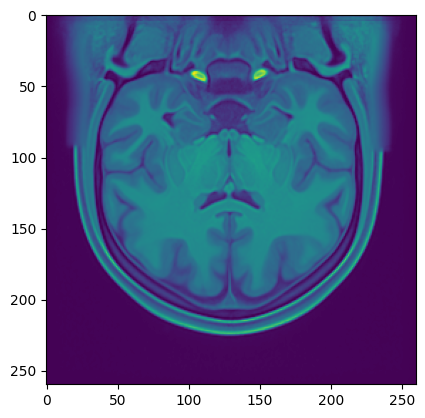

In [42]:
plt.imshow(atlas[:, S])



In [24]:
def eval_hastings(na, nb):
    image_A = itk.imread(
     f"/playpen-raid2/Data/HCP/HCP_1200/{na}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
    image_B = itk.imread(
     f"/playpen-raid2/Data/HCP/HCP_1200/{nb}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
    
    
    phi_AB, _ = itk_wrapper.register_pair(net, preprocess(image_A), preprocess(image_B), finetune_steps=50)
    
    image_A_seg = get_sub_seg(na)
    image_B_seg = get_sub_seg(nb)
    
    
    interpolator = itk.NearestNeighborInterpolateImageFunction.New(image_A_seg)
    warped_A = itk.resample_image_filter(image_A_seg, 
        transform=phi_AB, 
        interpolator=interpolator,
        use_reference_image=True, 
        reference_image=image_B_seg
    )

    return meanDICE(warped_A, image_B_seg)
#eval_hastings(NA, NB)

def eval_ants(na, nb):
    return meanDICE(get_ants_seg(na), get_ants_seg(nb))
    
import random
random.seed(1)

icon_dices = []
ants_dices = []

for _ in range(20):
    na = random.choice(atlas_registered)
    nb = random.choice(atlas_registered)
    
    icon_d = eval_hastings(na, nb)
    print("icon", icon_d)
    icon_dices.append(icon_d)
    ants_d = eval_ants(na, nb)
    print("ants", ants_d)
    ants_dices.append(ants_d)
    
print("final")
print("icon", np.mean(icon_dices))
print("ants", np.mean(ants_dices))

icon 0.7813606001925126
ants 0.7789688449216076
icon 0.8112338874457518
ants 0.7376296535317746
icon 0.7510346383760416
ants 0.7248291495038647
icon 0.7700213136841512
ants 0.7562280845695204
icon 0.7853846289592757
ants 0.7274173689692469
icon 0.7979605680416916
ants 0.7789420158351252
icon 0.8022816481887436
ants 0.7866718395036651
icon 0.7769643622031902
ants 0.7633299542410698
icon 0.7849995316673999
ants 0.7692476035458115
icon 0.8022278838905592
ants 0.7981401433813583
icon 0.7829331480423576
ants 0.7350234227770464
icon 0.7960302870982263
ants 0.7587897969101887
icon 0.7949464880607243
ants 0.7238468175069607
icon 0.8004715079602066
ants 0.7683031972517346
icon 0.7848069072434211
ants 0.7486039424706866
icon 0.775226103809265
ants 0.751596807573592
icon 0.8031604155693924
ants 0.7877281192486247
icon 1.0
ants 1.0
icon 0.7673950323965455
ants 0.7551630597562038
icon 0.7734548800820918
ants 0.7603287056802476
final
icon 0.7970946916455773
ants 0.7705394263589164


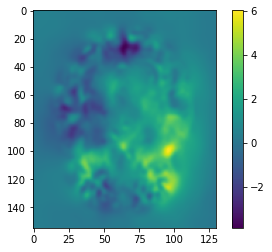

In [37]:
vf = phi_AB.GetNthTransform(1).GetParameters()
plt.imshow(np.array(vf).reshape(130, 155, 130, 3)[40, :, :, 2])
plt.colorbar()

In [36]:
vf = phi_AB.GetNthTransform(1).GetParameters()
plt.imshow(np.array(vf).reshape(65, 77, 65, 3)[20, :, :, 2])
plt.colorbar()

ValueError: cannot reshape array of size 7858500 into shape (65,77,65,3)

In [39]:
import pickle
import numpy as np
with open("training_scripts/brain_t1_pipeline/results/brain_train-1/loss_curve", "rb") as f:
    curve = pickle.load(f)
with open("training_scripts/brain_t1_pipeline/results/stripped_rg.05/loss_curve", "rb") as f:
    curve2 = pickle.load(f)

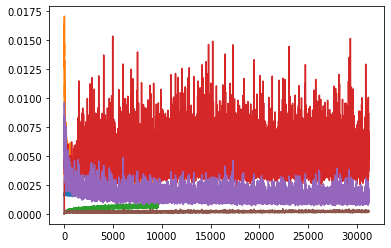

In [40]:
c = np.array([x[:3] for x in curve])
plt.plot(c)
c = np.array([x[:3] for x in curve2])
plt.plot(c)

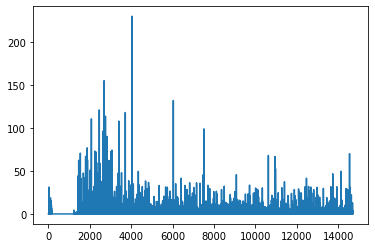

In [187]:
c = np.array([torch.mean(x[3].cpu()).item() for x in curve2])
plt.plot(c[:])

In [182]:
At = torch.tensor(np.array(image_A))[None, None]

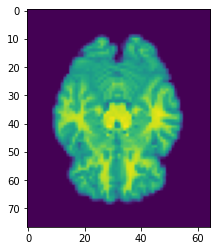

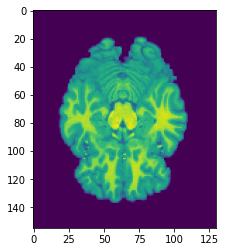

In [158]:
import torch.nn.functional as F
plt.imshow(F.avg_pool3d(At, 4)[0, 0, 20])
plt.show()
plt.imshow(F.avg_pool3d(At, 2)[0, 0, 40])